In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
import requests
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix

# Loading data

In [ ]:
drive.mount('/content/drive')

# Set the path to your Excel file
file_path = '/content/drive/My Drive/data/data_3.xlsx'
file_path2 = '/content/drive/My Drive/data/More_Info_Shbach.xlsx'

# Load the Excel file into a Pandas DataFrame
excel_file = pd.read_excel(file_path, sheet_name=None)
excel_file_Shbach = pd.read_excel(file_path2, sheet_name=None)

sheet1_data = excel_file['Sheet1']
sheet2_data = excel_file['Sheet2']
df_all = pd.concat([sheet1_data, sheet2_data])

df_Shbach = excel_file_Shbach['Sheet1']

df = pd.concat([df_all, df_Shbach])

Mounted at /content/drive


In [ ]:
df.shape

(1676669, 23)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1676669 entries, 0 to 473241
Data columns (total 23 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   P_ID                      1676669 non-null  int64         
 1   S_ID                      1676669 non-null  int64         
 2   Entry_Date                1676669 non-null  datetime64[ns]
 3   Departure_Date            1676669 non-null  object        
 4   Visa_Type                 1676669 non-null  object        
 5   EFather_Name              596758 non-null   object        
 6   HFather_Name              1203427 non-null  object        
 7   Hmother_Name              1203425 non-null  object        
 8   Country_code              1673023 non-null  object        
 9   Country_english_L         1676490 non-null  object        
 10  Country_english_U         1676490 non-null  object        
 11  Country                   1676669 non-null  object 

# Data cleaning

In [ ]:
df = df.replace("לא רשום","unknown")
df = df.replace("לא ידוע","unknown")
df = df.replace('ארץ לא ברורה )ב"ג(',"unknown")
df = df.replace('ארץ לא מוגדרת )ב"ג(',"unknown")
df = df.replace('אחר',"unknown")
df = df.replace('-',"unknown")
df = df.replace('בבירור',"unknown")
df = df.replace("גרוזיה","גאורגיה")
df = df.replace('שאר ארצות אסיה',"אסיה לא ידוע")

Download missing values:

In [ ]:
df_filtered = df[df['Country'] != 'unknown']
df_filtered = df_filtered[df_filtered['Date_birth'] != 'unknown']
df_filtered = df_filtered[df_filtered['Date_birth'] != '11/11/1111']

Download duplicates:

In [ ]:
df_unit_no_dup = df_filtered.drop_duplicates(subset=['Entry_Date', 'Departure_Date', 'Date_birth','Country'])
df_filtered = df_unit_no_dup

#Creating features

## Functions

In [ ]:
#----------------------above_90-----------------
def above_90_df(row):
    if not pd.isna(row['time_in']):
      val = row['time_in']
      return (int(float(val)) > 90)  & (row['If_show_improper'] == 'כן')
    elif row['If_show_improper'] == 'כן':
      pid = row['P_ID']
      other_rows = df_filtered.loc[(df_filtered['P_ID'] == pid) & (~df_filtered['time_in'].isna())]
      if other_rows.empty or (other_rows['time_in'].astype(float) <= 90).all():
          return True
    return False

#-------------------GDP----------------

# Set API parameters
url = 'https://api.worldbank.org/v2/country/'
indicator = 'NY.GDP.PCAP.CD'
format = 'json'

# Set pagination parameters
page = 1
per_page = 500
# Initialize list to store GDP per capita data for all countries
gdp_data = []
# Retrieve GDP per capita data for all countries
while True:
    # Construct API endpoint
    endpoint = f"{url}all/indicator/{indicator}?format={format}&per_page={per_page}&page={page}"
    # Make HTTP GET request to API endpoint
    response = requests.get(endpoint)
    # Get JSON response data
    data = response.json()[1]
    # Stop looping if no more data is available
    if not data:
        break
    # Append GDP per capita data to list
    gdp_data.extend(data)
    # Move to next page
    page += 1
# Convert list to pandas DataFrame
df_GDP = pd.DataFrame(gdp_data)

gdp_dict = {}

def get_gdp(row):
    country_code = row['Country_code']
    year = str(row['Entry_Date'].year)

    # Check if the year is 2022 or 2023
    if year in ['2022', '2023']:
        year = '2021'  # Set year to 2021

    if country_code in gdp_dict:
        if year in gdp_dict[country_code]:
            return gdp_dict[country_code][year]

    gdp = df_GDP[(df_GDP['countryiso3code'] == country_code) &
                 (df_GDP['date'] == year)]

    if len(gdp) > 0:
        value = gdp['value'].values[0]
        if country_code not in gdp_dict:
            gdp_dict[country_code] = {}
        gdp_dict[country_code][year] = value
        return value
    else:
        return None

#-----------------continent------------------
!pip install pycountry-convert

import pycountry_convert as pc

# Define a function to map countries to continents
def get_continent(country_name):
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return None

#-------------------HDI----FEATURES---------------
df_hdi = pd.read_csv('hdi.csv')
df_features = pd.read_excel('features.xlsx')
# df_Disaster = pd.read_excel('emdat_public.xlsx')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 46.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.7/228.7 kB 21.4 MB/s eta 0:00:00
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681832 sha256=9d32b9d23857b7f9e451ec68b1465eac24ece8ec92947bad2fdeee68571ac774
  Stored in directory: /root/.cache/pip/wheels/03/57/cc/290c5252ec97a6d78d36479a3c5e5ecc76318afcb241ad9dbe
Successfully built pycountry


## Features

In [ ]:
df_filtered['Entry_Date'] = pd.to_datetime(df_filtered['Entry_Date'])
df_filtered['Date_birth'] = pd.to_datetime(df_filtered['Date_birth'])

#-------------------------age_in_enter------------------------
df_filtered['age_in_enter'] = round((df_filtered['Entry_Date'] - df_filtered['Date_birth']).dt.days / 365)

#-------------------------time_in------------------------------
df_filtered['Departure_Date'] = pd.to_datetime(df_filtered['Departure_Date'], errors='coerce')
df_filtered['Entry_Date'] = pd.to_datetime(df_filtered['Entry_Date'], errors='coerce')
df_filtered['time_in'] = np.where(df_filtered['Departure_Date'].isna(), np.NAN, (df_filtered['Departure_Date'] - df_filtered['Entry_Date']).dt.days)
#------------------------
df_filtered = df_filtered.reset_index()

#----------------------country_bir_eq_to_pass--------------------
df_filtered['country_bir_eq_to_pass'] =  df_filtered['Country'] == df_filtered['Country_birth']
df_filtered.loc[df_filtered['Country_birth'] == 'unknown', 'country_bir_eq_to_pass'] = True
df_filtered.loc[(df_filtered['Country_birth'] == 'ברית המועצות') & (df_filtered['Country'].isin(['רוסיה', 'אוקראינה', 'מולדובה', 'אוזבקיסטן', 'גאורגיה', 'קזחסטאן', 'ארמניה', 'לטביה', 'תורכמניסטאן', 'ליטא', 'אסטוניה', 'בילורוסיה','אזרביג\'אן'])), 'country_bir_eq_to_pass'] = True

#-----------above_90-----------------
df_filtered['above_90'] = df_filtered.apply(above_90_df, axis=1)

#-------------------Interrogation-------------------
df_filtered['Interrogation'] = False
df_filtered.loc[df_filtered['Shows'].str.contains("תשאול"), 'Interrogation'] = True

#-------------------refugee-------------------
df_filtered['refugee'] = False
df_filtered.loc[df_filtered['Shows'].str.contains("מבקשי מקלט"), 'refugee'] = True

#-------------------month-------------------
df_filtered['month'] = df_filtered['Entry_Date'].dt.month

#-------------------year-------------------
df_filtered['year'] = df_filtered['Entry_Date'].dt.year

#---------------GDP-------------
df_filtered['GDP'] = df_filtered.apply(get_gdp, axis=1)

unique_values = df_filtered['GDP'].unique()
mean_value = unique_values.mean()
df_filtered['GDP'].replace([np.inf, -np.inf, np.nan], mean_value, inplace=True)

#-------------continent-----------------------
df_filtered['Country_english_upper'] = df_filtered['Country_english_L'].str.title()
df_filtered['Country_english_upper'] = df_filtered['Country_english_upper'].replace('Usa', 'United States of America')
df_filtered['Country_english_upper'] = df_filtered['Country_english_upper'].replace('Korea', 'South Korea')
df_filtered['Country_english_upper'] = df_filtered['Country_english_upper'].replace('S Africa', 'Republic of South Africa')

df_filtered['continent'] = df_filtered['Country_english_upper'].apply(get_continent)

#-------------HDI-----------------
df_filtered = df_filtered.merge(df_hdi[['Country Code', 'HDI']], left_on='Country_code', right_on='Country Code', how='left')
df_filtered['HDI'] = df_filtered['HDI'].fillna(df_filtered['HDI'].mean())

#------------features-----------
df_filtered['Country_english_L'] = df_filtered['Country_english_L'].replace('russian federation', 'russia')
df_filtered['Country_english_L'] = df_filtered['Country_english_L'].replace('s africa', 'south africa')

df_features_unique = df_features.drop_duplicates(subset=['Country_sec'], keep='first')
df_filtered['Security_threat_index'] = df_filtered['Country_english_L'].map(df_features_unique.set_index('Country_sec')['Security_threat_index'])
df_features_unique = df_features.drop_duplicates(subset=['Country_demo'], keep='first')
df_filtered['Quality_of_Democracy'] = df_filtered['Country_english_L'].map(df_features_unique.set_index('Country_demo')['Quality_of_Democracy'])
df_features_unique = df_features.drop_duplicates(subset=['Country_den'], keep='first')
df_filtered['Density'] = df_filtered['Country_english_L'].map(df_features_unique.set_index('Country_den')['Density'])

unique_values = df_filtered['Density'].unique()
mean_value = unique_values.mean()
df_filtered['Density'] = df_filtered['Density'].fillna(mean_value)

unique_values = df_filtered['Quality_of_Democracy'].unique()
mean_value = unique_values.mean()
df_filtered['Quality_of_Democracy'] = df_filtered['Quality_of_Democracy'].fillna(mean_value)

unique_values = df_filtered['Security_threat_index'].unique()
mean_value = unique_values.mean()
df_filtered['Security_threat_index'] = df_filtered['Security_threat_index'].fillna(mean_value)


## Future features

In [ ]:
#------------------------num_visit-----------------------------
# df_filtered['Entry_Date'] = pd.to_datetime(df_filtered['Entry_Date'])  # convert to datetime if necessary
# df_filtered['num_visit'] = df_filtered.groupby('P_ID')['Entry_Date'].rank(method='dense', ascending=False) - df_filtered.groupby('P_ID')['Entry_Date'].rank(method='dense', ascending=True).iloc[-1] + 1
# df_filtered['num_visit'] = df_filtered.groupby('P_ID')['num_visit'].apply(lambda x: x.max() - x)
# df_filtered['num_visit'] = df_filtered['num_visit'].astype(int)

#--------------avg_time_in-----------------
# df_filtered['days_from_prev_visit'] = (df_filtered['Entry_Date'] - df_filtered.groupby('P_ID')['Departure_Date'].shift()).fillna(pd.Timedelta(0)).dt.total_seconds() / (24 * 60 * 60)
# df_filtered['dup_time_in'] = df_filtered['time_in'].fillna(0)
# df_filtered['dup_time_in'].fillna('missing', inplace=True)
# cumsum = df_filtered.groupby('P_ID')['dup_time_in'].cumsum() - df_filtered['dup_time_in'].fillna(0)
# cumcount = df_filtered.groupby('P_ID')['dup_time_in'].cumcount() - df_filtered['dup_time_in'].isna().cumsum()
# df_filtered['avg_time_in'] = cumsum / cumcount.fillna(0)
# df_filtered['avg_time_in'] = df_filtered['avg_time_in'].fillna(0)

# df_filtered['avg_time_in'] = df_filtered.groupby('P_ID')['time_in'].rolling(window=2, min_periods=1).mean().reset_index(0, drop=True)


##last filter

In [ ]:
df_filtered_15 = df_filtered[df_filtered['age_in_enter'] >= 15]

In [ ]:
df_filtered_15 = df_filtered_15.loc[~((df_filtered_15['above_90'] == False) & (df_filtered_15['Departure_Date'].isnull()))]

# population segmentation

filtter visa:

In [ ]:
filtter_visa = ['ב/2', 'ב/1', 'ב/1 כללי','ב/2 קבוצתי']
df = df_filtered_15[df_filtered_15['Visa_Type'].isin(filtter_visa)]

filltter 15 countres:

In [ ]:
filtter_country_code = ['FJI','TUR', 'MDA','CHN','COL','IND','PHL','ROU','BRA','ETH','POL','SGS','NGA','RUS','UKR']
df_t = df[df['Country_code'].isin(filtter_country_code)]

## without filttred 15 countres - all countres:
# df_t = df

In [ ]:
# df_Disaster = pd.read_excel('emdat_public.xlsx')

In [ ]:
# import datetime

# df_t['Disaster'] = df_t.apply(lambda row: any(
#     (df_Disaster['ISO'] == row['Country_code']) &
#     (df_Disaster['Start Year'] == row['year']) &
#     (df_Disaster['Start Month'] <= row['month']) &
#     (
#         (
#             (df_Disaster['End Year'] == row['year']) &
#             (df_Disaster['End Month'] >= row['month'])
#         ) |
#         (
#             (df_Disaster['End Year'] > row['year']) |
#             (
#                 (df_Disaster['End Year'].isnull()) &
#                 (df_Disaster['End Month'].isnull()) &
#                 (datetime.datetime.now().year > row['year']) |
#                 (
#                     datetime.datetime.now().year == row['year'] and
#                     datetime.datetime.now().month > row['month']
#                 )
#             )
#         )
#     )
# ), axis=1)

<ipython-input-25-ea4e2091aa74>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['Disaster'] = df_t.apply(lambda row: any(


In [ ]:
# df_t.loc[:,["month","year", "Country_code", "Disaster"]]

,month,year,Country_code,Disaster
4,2,2018,PHL,True
9,12,2018,NGA,False
13,10,2018,UKR,False
14,11,2018,PHL,True
16,5,2018,IND,True
...,...,...,...,...
1663462,11,2022,MDA,False
1663463,11,2022,MDA,False
1663465,9,2022,RUS,False
1663466,9,2022,RUS,False


### Checking if the data distribution reflects the office report

Deleting countries that do not have multiple records

In [ ]:
# # Get the number of samples for each class
# class_counts = df_t['Country'].value_counts()

# # Get the list of classes with at least 40 samples
# valid_classes = class_counts[class_counts >= 3000].index.tolist()

# # Filter the DataFrame to keep only the rows with valid classes
# df_t = df_t[df_t['Country'].isin(valid_classes)]

In [ ]:
df_check = df_t[df_t['above_90']==True]
df_check.Country.value_counts()

אוקראינה     43684
רוסיה        24695
גאורגיה      12574
הודו          9244
פיליפינים     9163
סין           6533
מולדובה       6346
רומניה        4181
ברזיל         3909
תורכיה        3567
קולומביה      2678
ניגריה        1717
אתיופיה       1508
פולין          849
איי פיגי       679
Name: Country, dtype: int64

#Coding columns

###State Severity Rating:

In [ ]:
def create_bin_dan_country(country):
    if country in ['רוסיה', 'אוקראינה']:
        return 1
    elif country in ['גאורגיה', 'ניגריה']:
        return 2
    elif country in ['פולין','אתיופיה','ברזיל','רומניה']:
        return 3
    elif country in ['פיליפינים','הודו','קולומביה']:
        return 4
    else:
        return 5

# use the apply function to create the new column
df_t['Country_lab'] = df_t['Country'].apply(create_bin_dan_country)

<ipython-input-14-c1d39ec88727>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['Country_lab'] = df_t['Country'].apply(create_bin_dan_country)


###Distribution for use in the entire population:

In [ ]:
# df_t['age_in_enter']= pd.cut(df_t['age_in_enter'], bins=20)
# df_t['GDP']= pd.cut(df_t['GDP'], bins=35)
# df_t['Security_threat_index']= pd.cut(df_t['Security_threat_index'], bins=39)
# df_t['Density']= pd.cut(df_t['Density'], bins=60)
# df_t['Quality_of_Democracy']= pd.cut(df_t['Quality_of_Democracy'], bins=42)
# df_t['HDI']= pd.cut(df_t['HDI'], bins=7)

###Distribution for use in the problematic countries only:

In [ ]:
df_t['age_in_enter']= pd.cut(df_t['age_in_enter'], bins=10)
df_t['GDP']= pd.cut(df_t['GDP'], bins=7)
df_t['Security_threat_index']= pd.cut(df_t['Security_threat_index'], bins=7)
df_t['Density']= pd.cut(df_t['Density'], bins=7)
df_t['Quality_of_Democracy']= pd.cut(df_t['Quality_of_Democracy'], bins=7)
df_t['HDI']= pd.cut(df_t['HDI'], bins=7)

<ipython-input-15-9139628393e1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['age_in_enter']= pd.cut(df_t['age_in_enter'], bins=10)
<ipython-input-15-9139628393e1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['GDP']= pd.cut(df_t['GDP'], bins=7)
<ipython-input-15-9139628393e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

###Converting feature values ​​to numeric tags:

In [ ]:
le = LabelEncoder()
df_t['Country_bir_e'] = le.fit_transform(df_t['Country_birth'])
df_t['Gender_e'] = le.fit_transform(df_t['Gender'])
df_t['Personal_situation_e'] = le.fit_transform(df_t['Personal_situation'])
df_t['country_bir_eq_to_pass_e'] = le.fit_transform(df_t['country_bir_eq_to_pass'])
df_t['Visa_Type_e'] = le.fit_transform(df_t['Visa_Type'])
df_t['Interrogation_e'] = le.fit_transform(df_t['Interrogation'])
df_t['refugee_e'] = le.fit_transform(df_t['refugee'])
df_t['Visa_requirement_e'] = le.fit_transform(df_t['Visa_requirement'])
df_t['continent_e'] = le.fit_transform(df_t['continent'])
df_t['age_in_enter_e'] = le.fit_transform(df_t['age_in_enter'])
df_t['GDP_e'] = le.fit_transform(df_t['GDP'])
df_t['Security_threat_index_e'] = le.fit_transform(df_t['Security_threat_index'])
df_t['Density_e'] = le.fit_transform(df_t['Density'])
df_t['Quality_of_Democracy_e'] = le.fit_transform(df_t['Quality_of_Democracy'])
df_t['HDI_e'] = le.fit_transform(df_t['HDI'])
# df_t['Disaster_e'] = le.fit_transform(df_t['Disaster'])

<ipython-input-16-c2c6f82c8704>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['Country_bir_e'] = le.fit_transform(df_t['Country_birth'])
<ipython-input-16-c2c6f82c8704>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['Gender_e'] = le.fit_transform(df_t['Gender'])
<ipython-input-16-c2c6f82c8704>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

# The model

## division to train(50/50) + test(90/10)

In [ ]:
shbach = df_t[df_t['above_90']==True]
no_shbach = df_t[df_t['above_90']==False]
print(shbach.shape)
print(no_shbach.shape)

(131327, 56)
(322555, 56)


calculte how to splite the data

In [ ]:
probability = 0.1
M_probability = 1 - probability
size_test = 0.2

x1 = int((shbach.shape[0]*2*size_test*probability)/(1- size_test+2*size_test*probability)) # The min in shbach
x2 = int((2*probability*size_test*no_shbach.shape[0])/(1-size_test+M_probability*size_test*2))  # The min in no_shbach
x = min(x1,x2)
y = int((x/probability)*M_probability)
half = int((x/probability)/size_test-(x/probability))/2
print(x,y, x2)
print(half)

stat1 = (x+half)/shbach.shape[0]
if stat1 > 0.9998:
  stat1 = 0.9998
stat2 = x/(x+half)
stat3 = (y+half)/no_shbach.shape[0]
if stat3 > 0.9998:
  stat3 = 0.9998
stat4 = y/(y+half)
print(stat1, stat2)
print(stat3, stat4)

6253 56277 11122
125060.0
0.9998 0.047619047619047616
0.5621893940568276 0.3103448275862069


In [ ]:
from sklearn.model_selection import train_test_split
not_for_model, for_model = train_test_split(shbach, test_size=stat1, stratify=shbach['Country'])
train_sh, test_sh = train_test_split(for_model, test_size=stat2, stratify=for_model['Country'])
not_for_model_1, for_model_1 = train_test_split(no_shbach, test_size=stat3, stratify=no_shbach['Country'])
train_no_sh, test_no_sh = train_test_split(for_model_1, test_size=stat4, stratify=for_model_1['Country'])
train_df = pd.concat([train_sh,train_no_sh])
test_df = pd.concat([test_sh,test_no_sh])
print(for_model.shape)
print(test_sh.shape)
print(for_model_1.shape)
print(test_no_sh.shape)

(131301, 56)
(6253, 56)
(181337, 56)
(56277, 56)


##RF model

No cross validation

In [ ]:
# # Define the list of features to use in the model
# featues_list = ['Country_lab', 'country_bir_eq_to_pass','Country_bir_e', 'Personal_situation_e', 'age_in_enter_e', 'Visa_Type_e', 'refugee_e', 'month', 'Visa_requirement_e','GDP_e','HDI_e', 'Security_threat_index_e', 'Quality_of_Democracy_e','continent_e', 'Density_e']
# #'Disaster_e',  'Gender_e',
# # Train a Random Forest classifier with 50 estimators
# rf = RandomForestClassifier(n_estimators=150, random_state=42)
# rf.fit(train_df[featues_list], train_df["above_90"].values)

# # Predict the target variable on the test set
# prob_predictions = rf.predict_proba(test_df[featues_list])
# threshold_predictions = np.where(prob_predictions[:,1] > 0.3, 1, 0)

# # Compute the accuracy and recall scores
# accuracy = accuracy_score(test_df["above_90"].values, threshold_predictions)
# recall = recall_score(test_df["above_90"].values, threshold_predictions)

# # Calculate the confusion matrix
# cm = confusion_matrix(test_df["above_90"].values, threshold_predictions)

# # Print the confusion matrix
# print("Confusion Matrix:")
# print(cm)

# # Print the scores
# print(f"Accuracy: {accuracy}")
# print(f"Recall: {recall}")

ValueError: ignored

with cross validation

In [ ]:
from sklearn.model_selection import cross_val_score

# Define the list of features to use in the model
features_list = ['Country_lab', 'Country_bir_e', 'Personal_situation_e', 'age_in_enter_e', 'Visa_Type_e', 'refugee_e', 'month', 'GDP_e', 'HDI_e', 'Security_threat_index_e', 'Quality_of_Democracy_e', 'Density_e']
#['Country_lab', 'country_bir_eq_to_pass', 'Country_bir_e', 'Personal_situation_e', 'age_in_enter_e', 'Visa_Type_e', 'refugee_e', 'month', 'Visa_requirement_e', 'GDP_e', 'HDI_e', 'Security_threat_index_e', 'Quality_of_Democracy_e', 'continent_e', 'Density_e']

#'Country_lab', 'country_bir_eq_to_pass', 'Country_bir_e', 'Personal_situation_e', 'age_in_enter_e', 'Visa_Type_e', 'refugee_e', 'month', 'Visa_requirement_e', 'GDP_e', 'HDI_e', 'Security_threat_index_e', 'Quality_of_Democracy_e', 'continent_e', 'Density_e']
#'Disaster_e',  'Gender_e',

# Train a Random Forest classifier with 150 estimators
rf = RandomForestClassifier(n_estimators=150, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(rf, train_df[features_list], train_df["above_90"].values, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:")
print(cv_scores)
print("Mean CV Accuracy: ", cv_scores.mean())

# Fit the model on the entire training set
rf.fit(train_df[features_list], train_df["above_90"].values)

# Predict the target variable on the test set
prob_predictions = rf.predict_proba(test_df[features_list])
threshold_predictions = np.where(prob_predictions[:, 1] > 0.3, 1, 0)

# Compute the accuracy and recall scores
accuracy = accuracy_score(test_df["above_90"].values, threshold_predictions)
recall = recall_score(test_df["above_90"].values, threshold_predictions)

# Calculate the confusion matrix
cm = confusion_matrix(test_df["above_90"].values, threshold_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Print the scores
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")


Cross-Validation Scores:
[0.81010355 0.81268242 0.81384191 0.80940005 0.80708103]
Mean CV Accuracy:  0.8106217923356841
Confusion Matrix:
[[38507 17770]
 [  784  5469]]
Accuracy: 0.7032784263553494
Recall: 0.8746201823124901


#Receiving the importance of eche feathre


In [ ]:
importances = rf.feature_importances_

# Create a dictionary mapping feature names to their importances
feature_importance_dict = dict(zip(featues_list, importances))

# Print the feature importances
for feature, importance in feature_importance_dict.items():
    print(f"{feature}: {importance}")

Country_lab: 0.027753512718639746
country_bir_eq_to_pass: 0.021258773731726667
Country_bir_e: 0.19269386583807815
Personal_situation_e: 0.0417985296391306
age_in_enter_e: 0.054923079805692894
Visa_Type_e: 0.06958445033027426
refugee_e: 0.2623821341411594
month: 0.06692420979088574
Visa_requirement_e: 0.009760708136613441
GDP_e: 0.08919675952631315
HDI_e: 0.022301028585847937
Security_threat_index_e: 0.0483461935508502
Quality_of_Democracy_e: 0.050794159422091624
continent_e: 0.01767197242513335
Density_e: 0.024610622357563006


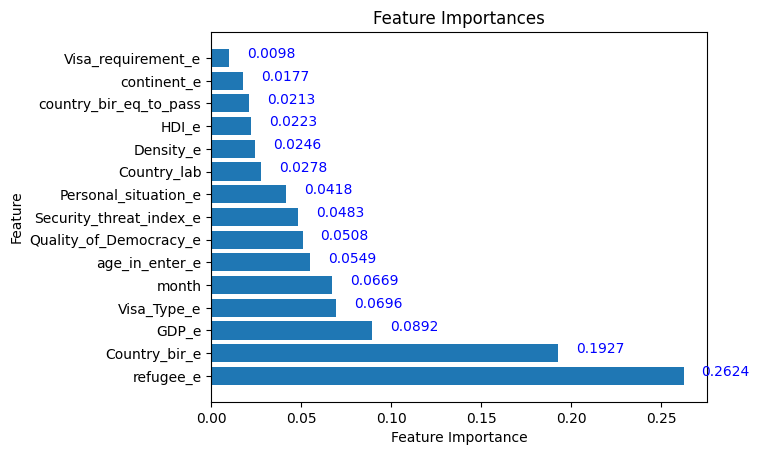

In [ ]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_

# Create a dictionary mapping feature names to their importances
feature_importance_dict = dict(zip(featues_list, importances))

# Sort the feature importances in descending order
sorted_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Extract the feature names and importances for plotting
features, importances = zip(*sorted_importances)

# Create a horizontal bar plot
plt.barh(range(len(features)), importances)
plt.yticks(range(len(features)), features)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")

# Add numerical values on each bar
for i, v in enumerate(importances):
    plt.text(v + 0.01, i, str(round(v, 4)), color='blue')

# Display the plot
plt.show()
